# Predictivity measures

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itr import Itr
from sklearn.metrics import f1_score

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    Month,
    extract_crime_data,
    random_crime_data_by_feature,
)

In [39]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "GRID"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 200.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
AREA_THRESHOLDS = [0.5, 0.25, 0.1]

In [40]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE, filters={"Crime type": CATEGORY})
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


In [41]:
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

count_data = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(count_data) == len(features)

count_data

Month,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80601,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## F1 score bounds

In this context an "event" is a given spatial unit being in the set of spatial units that comprise the top $n$% of crimes.

For events occurring with probability $p$ and and a purely random (i.e. non-predictive) predictor, the normalised confusion matrix is

$$
\begin{bmatrix}
p \\
1-p
\end{bmatrix}
\otimes
\begin{bmatrix}
p \\
1-p
\end{bmatrix}
=
\begin{bmatrix}
p^2 & p(1-p) \\
p(1-p) & (1-p)^2
\end{bmatrix}
$$

The $F1$ score is given by

$$
F1 = \frac{2TP}{2TP + FP + FN}
$$

where $TP$, $FP$ and $FN$ are the number of true positives, false positives and false negatives respectively. Thus for purely random "predictions" of an event with probability $p$. Thus for a purely random confusion matrix,

$$
F1 = \frac{2p^2}{2p^2+2p(1-p)} = p
$$

For reference, both *precision* ($P = TP/(TP+FP)$) and *recall* ($R = TP/(TP+FN)$) are also equal to $p$ - $F1$ is the harmonic mean of the two. Note that true negatives (the majority of the data in our case) do not feature in the formula.

This gives us a lower bound of $p$ for the predictability of crime hotspots. A value lower than $p$ would imply effort on the perpetrators to change the locations where crimes are committed, implying some degree of premeditation. The upper bound for $p$ is 1, which would occur when the prediction is identical to the target.

Given (say) 36 months of crime data (with month temporal resolution), we take the final month as the "target", and measure its predictability against various combinations of the preceding months.

### Comparison against "overlap" measure

The overlap measure used in *Mohler et al* compares the spatial units that host the top $N$% of crimes for each time period. Although not defined explicitly in their work, the overlap measure could be:

$$
O = \frac{\big|C_1 \cap C_2\big|}{\big|C_1 \cup C_2\big|}
$$

Put in F1 terms, the intersection is the count of true positives, and the union the count of all but true negatives:

$$
O = \frac{TP}{TP+FP+FN}
$$

Now consider a case where we have 2 sets of 10 positives, but only one positive is in both sets. The overlap score using the formula above gives 1/(1 + 9 + 9) which has the somewhat counterintuitive value of 1/19 when we have a 1-in-10 overlap. A more intuitive formula would be to use the mean of the false positives and false negatives - giving 1/10 - and this turns out to be identical to the F1 score:

$$
O = \frac{TP}{TP+(FP+FN)/2} = \frac{2TP}{2TP+FP+FN} = F1
$$


In [64]:
rng = np.random.default_rng(19937)

p = 0.2
N = 1000000

a_p = rng.choice([1, 0], p=[p, 1 - p], size=(N, 2))

confusion_matrix = np.zeros((2, 2))

for trial in a_p:
    confusion_matrix[*trial] += 1
confusion_matrix /= N


confusion_matrix - np.outer([p, 1 - p], [p, 1 - p])

print(f"independent: {f1_score(a_p[:, 0], a_p[:, 1])}")
print(f"identical: {f1_score(a_p[:, 0], a_p[:, 0])}")
print(f"50-50: {f1_score(a_p[:, 0], np.concatenate([a_p[: N // 2, 0], a_p[: N // 2, 1]]))}")
print(f"25-75: {f1_score(a_p[:, 0], np.concatenate([a_p[: N // 4, 0], a_p[: 3 * N // 4, 1]]))}")
print(f"75-25: {f1_score(a_p[:, 0], np.concatenate([a_p[: 3 * N // 4, 0], a_p[: N // 4, 1]]))}")

independent: 0.20070963512343548
identical: 1.0
50-50: 0.5998539612997444
25-75: 0.400127175502193
75-25: 0.7993507079087384


In [65]:
threshold_probs = pd.Series(index=AREA_THRESHOLDS, name="p")

for threshold in AREA_THRESHOLDS:
    threshold_probs.loc[threshold] = sum(
        ((col.sort_values().cumsum() / col.sum()) >= (1 - threshold)).mean() for _, col in count_data.items()
    ) / len(count_data.columns)

threshold_probs

0.50    0.042565
0.25    0.013773
0.10    0.003767
Name: p, dtype: float64

In [66]:
def calc_threshold_f1_impl(pred_target: pd.DataFrame, threshold: float):
    ranked = pd.concat([col.sort_values().cumsum() / col.sum() for _, col in pred_target.items()], axis=1).sort_index()

    result = ranked > 1 - threshold

    return f1_score(result.target, result.pred)


def calc_threshold_f1(count_data: pd.DataFrame) -> pd.DataFrame:
    threshold_f1 = pd.DataFrame(index=range(1, len(count_data.columns)), columns=AREA_THRESHOLDS)

    # last available month is the "target"
    target = count_data.iloc[:, -1].rename("target")
    for threshold in AREA_THRESHOLDS:
        for i in threshold_f1.index:
            pred_target = pd.concat([count_data.iloc[:, -(i + 1) : -1].mean(axis=1).rename("pred"), target], axis=1)
            threshold_f1.loc[i, threshold] = calc_threshold_f1_impl(pred_target, threshold)
    return threshold_f1


threshold_f1 = calc_threshold_f1(count_data)

In [67]:
# TODO sampling points in polygon biases toward larger spatial units
ref_crime_data = random_crime_data_by_feature(len(raw_crime_data), features, list(raw_crime_data.Month.unique()))

ref_count_data = (
    ref_crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(ref_count_data) == len(features)

ref_threshold_probs = pd.Series(index=AREA_THRESHOLDS, name="p")

for threshold in AREA_THRESHOLDS:
    ref_threshold_probs.loc[threshold] = sum(
        ((col.sort_values().cumsum() / col.sum()) >= (1 - threshold)).mean() for _, col in ref_count_data.items()
    ) / len(ref_count_data.columns)

ref_threshold_f1 = calc_threshold_f1(ref_count_data)
ref_threshold_f1

,0.50,0.25,0.10
1,0.152642,0.040089,0.028571
2,0.211765,0.086142,0.011765
3,0.189792,0.098976,0.010471
4,0.198484,0.096931,0.009852
5,0.205767,0.096124,0.028169
6,0.206722,0.109467,0.035714
7,0.223053,0.135252,0.043478
8,0.216941,0.135021,0.050633
9,0.208633,0.124138,0.057613
10,0.21196,0.11908,0.063745


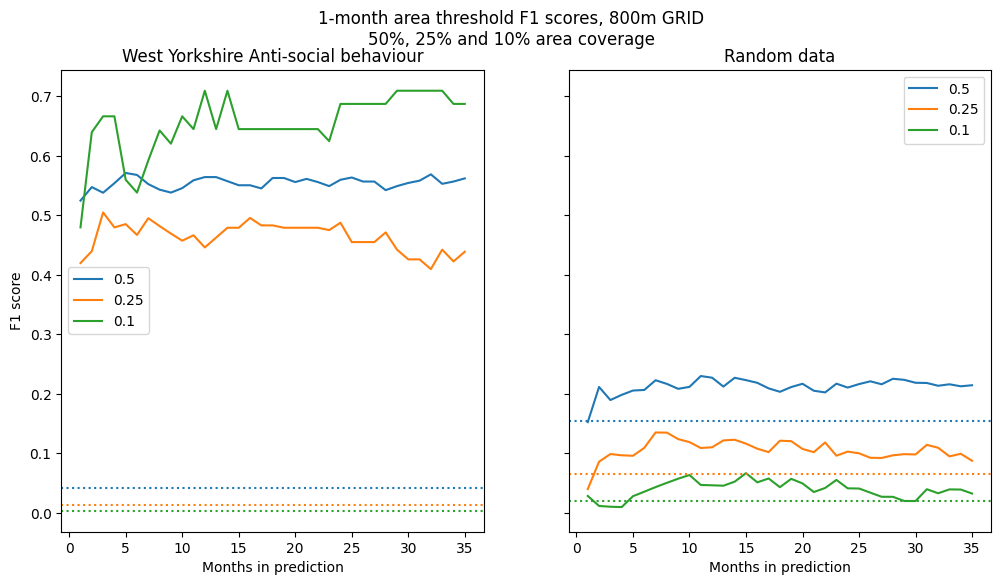

In [68]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

fig.suptitle(
    f"1-month area threshold F1 scores, {AREA_PARAMETERS[AREA].get('size', 0):.0f}m {AREA}\n50%, 25% and 10% area coverage"
)

threshold_f1.plot(ax=axs[0], title=f"{FORCE} {CATEGORY}")
axs[0].set_xlabel("Months in prediction")
axs[0].set_ylabel("F1 score")
for i, (_, p) in enumerate(threshold_probs.items()):
    axs[0].axhline(p, ls=":", c=axs[0].lines[i].get_color())
ref_threshold_f1.plot(ax=axs[1], title="Random data")
axs[1].set_xlabel("Months in prediction")
for i, (_, p) in enumerate(ref_threshold_probs.items()):
    axs[1].axhline(p, ls=":", c=axs[1].lines[i].get_color())

## Next steps

### Area coverage required to achive F1 value above X%


### Optimal spatial unit size